# Key EDA Findings: San Diego Police Stops + SVI

A focused summary of the most revealing analyses—combining **top graphs** with **non-graph EDA** (tables, summary stats, cross-tabulations).

## 1. Setup & Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./data/sopp_svi_merged.csv')
df['search_conducted'] = (df['search_conducted'] == True) | (df['search_conducted'] == 'True')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour
df['is_night'] = (df['hour'] >= 18) | (df['hour'] < 6)

print("Shape:", df.shape)
print("Years:", sorted(df['year'].dropna().unique().astype(int).tolist()))

Shape: (383027, 29)
Years: [2014, 2015, 2016, 2017]


## 2. Non-Graph EDA: Key Tables & Summary Stats

### 2.1 Target Variable Summary

In [2]:
n_total = len(df)
n_searched = df['search_conducted'].mean() * n_total
overall_rate = df['search_conducted'].mean() * 100

print("=== search_conducted (target) ===")
print(f"Total stops: {n_total:,}")
print(f"Stops with search: {int(n_searched):,}")
print(f"Overall search rate: {overall_rate:.2f}%")
print(f"\nBy year:")
yr = df.groupby('year')['search_conducted'].agg(['mean', 'sum'])
yr['rate_pct'] = (yr['mean'] * 100).round(2).astype(str) + '%'
print(yr[['rate_pct', 'sum']])

=== search_conducted (target) ===
Total stops: 383,027
Stops with search: 16,288
Overall search rate: 4.25%

By year:
       rate_pct   sum
year                 
2014.0    4.92%  6855
2015.0    3.77%  4251
2016.0    3.81%  3914
2017.0    4.38%  1234


### 2.2 Search Rate by Key Groups (Table)

In [3]:
overall_rate = df['search_conducted'].mean()
tmp = df.dropna(subset=['svi_rpl_themes', 'search_conducted']).copy()
tmp['search_01'] = tmp['search_conducted'].astype(int)
tmp['svi_quartile'] = pd.qcut(tmp['svi_rpl_themes'], 4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

svi_summary = tmp.groupby('svi_quartile').agg(
    n=('search_01', 'size'),
    search_rate=('search_01', 'mean')
).reset_index()
svi_summary['search_rate_pct'] = (svi_summary['search_rate'] * 100).round(2)
svi_summary['ratio_to_baseline'] = (svi_summary['search_rate'] / overall_rate).round(2)

race_summary = df.groupby('subject_race').agg(
    n=('search_conducted', 'size'),
    search_rate=('search_conducted', lambda x: x.eq(True).mean())
).reset_index()
race_summary['search_rate_pct'] = (race_summary['search_rate'] * 100).round(2)
race_summary['ratio_to_baseline'] = (race_summary['search_rate'] / overall_rate).round(2)
race_summary = race_summary.sort_values('search_rate', ascending=False)

print("=== Search rate by SVI quartile ===")
print(svi_summary[['svi_quartile', 'n', 'search_rate_pct']].to_string(index=False))
print("\n=== Search rate by race (top 6) ===")
print(race_summary.head(6)[['subject_race', 'n', 'search_rate_pct']].to_string(index=False))

=== Search rate by SVI quartile ===
svi_quartile      n  search_rate_pct
    Q1 (low) 100062             2.89
          Q2 106168             2.91
          Q3  78279             5.54
   Q4 (high)  86891             6.50

=== Search rate by race (top 6) ===
          subject_race      n  search_rate_pct
                 black  42705             9.07
              hispanic 117083             5.55
asian/pacific islander  32541             2.80
                 white 162226             2.78
                 other  27238             1.66


/var/folders/13/4gcchqp1423dk8lllkh6qns00000gn/T/ipykernel_12219/2526859459.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  svi_summary = tmp.groupby('svi_quartile').agg(


### 2.3 Cross-Tabulation: Race × SVI Quartile

In [4]:
top_races = tmp['subject_race'].value_counts().head(5).index.tolist()
tmp_race = tmp[tmp['subject_race'].isin(top_races)]
race_svi = tmp_race.groupby(['subject_race', 'svi_quartile'])['search_01'].mean().unstack()
race_svi_pct = (race_svi * 100).round(2)

print("=== Search rate (%) by Race × SVI quartile ===")
print(race_svi_pct.to_string())
print("\nInsight: Black subjects have the highest search rate in every SVI quartile.")

=== Search rate (%) by Race × SVI quartile ===
svi_quartile            Q1 (low)    Q2    Q3  Q4 (high)
subject_race                                           
asian/pacific islander      1.99  1.56  4.67       5.58
black                       5.09  5.82  9.37      13.16
hispanic                    4.50  4.59  7.99       5.36
other                       1.27  1.42  1.85       3.49
white                       2.65  2.32  3.23       4.83

Insight: Black subjects have the highest search rate in every SVI quartile.


/var/folders/13/4gcchqp1423dk8lllkh6qns00000gn/T/ipykernel_12219/3392275766.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_svi = tmp_race.groupby(['subject_race', 'svi_quartile'])['search_01'].mean().unstack()


## 3. Top Graphs

### Graph 1: Search Rate by SVI Quartile

**Insight:** Search rates rise sharply with neighborhood vulnerability. Q4 (highest SVI) has ~2.3× the search rate of Q1. Place matters.

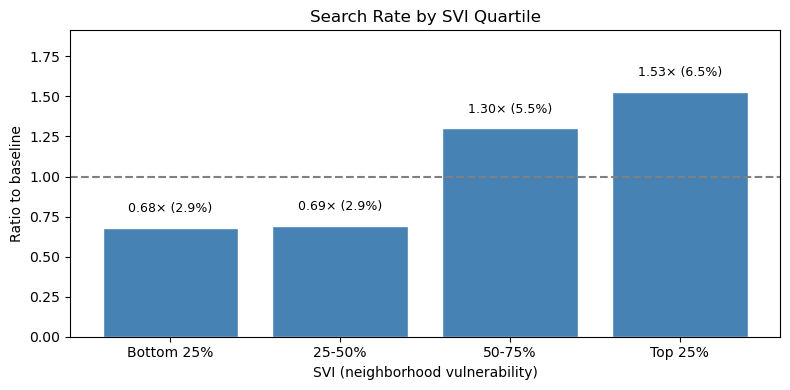

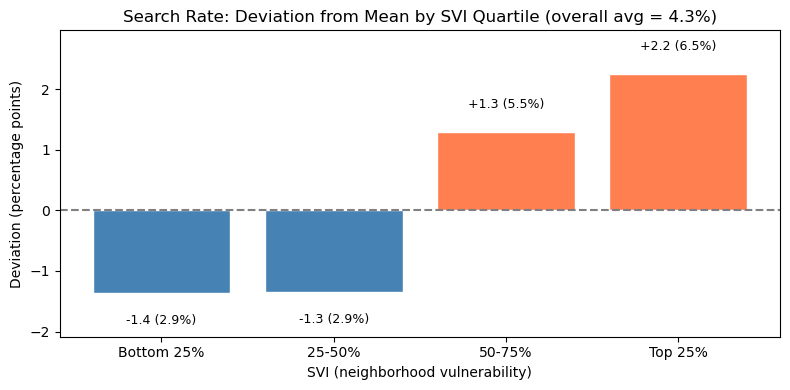

In [5]:
# X-axis labels: vulnerability percentile
svi_labels = {'Q1 (low)': 'Bottom 25%', 'Q2': '25-50%', 'Q3': '50-75%', 'Q4 (high)': 'Top 25%'}
svi_summary['x_label'] = svi_summary['svi_quartile'].astype(str).map(svi_labels)

# Graph 1a: Ratio to baseline
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(svi_summary['x_label'], svi_summary['ratio_to_baseline'], color='steelblue', edgecolor='white')
ax.axhline(1.0, color='gray', linestyle='--', label='Baseline (overall avg)')
ax.set_title('Search Rate by SVI Quartile')
ax.set_ylabel('Ratio to baseline')
ax.set_xlabel('SVI (neighborhood vulnerability)')
# Add headroom for labels
ymax = svi_summary['ratio_to_baseline'].max()
ax.set_ylim(top=ymax * 1.25)
bbox_props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='none')
for bar, ratio, pct in zip(bars, svi_summary['ratio_to_baseline'], svi_summary['search_rate_pct']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08, f'{ratio:.2f}× ({pct:.1f}%)', ha='center', va='bottom', fontsize=9, bbox=bbox_props)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Graph 1b: Deviation from mean (percentage points)
overall_rate_pct = overall_rate * 100
svi_summary['deviation_pp'] = svi_summary['search_rate_pct'] - overall_rate_pct
fig, ax = plt.subplots(figsize=(8, 4))
vals = svi_summary['deviation_pp']
colors = ['steelblue' if v < 0 else 'coral' for v in vals]
bars = ax.bar(svi_summary['x_label'], vals, color=colors, edgecolor='white')
ax.axhline(0, color='gray', linestyle='--', label='Overall mean')
ax.set_title(f'Search Rate: Deviation from Mean by SVI Quartile (overall avg = {overall_rate_pct:.1f}%)')
ax.set_ylabel('Deviation (percentage points)')
ax.set_xlabel('SVI (neighborhood vulnerability)')
# Add headroom above and below for labels
ax.margins(y=0.2)
bbox_props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='none')
for bar, dev, pct in zip(bars, svi_summary['deviation_pp'], svi_summary['search_rate_pct']):
    y = bar.get_height()
    va = 'bottom' if y >= 0 else 'top'
    offset = 0.35 if y >= 0 else -0.35
    ax.text(bar.get_x() + bar.get_width()/2, y + offset, f'{dev:+.1f} ({pct:.1f}%)', ha='center', va=va, fontsize=9, bbox=bbox_props)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Graph 2: Search Rate by Race

**Insight:** Search rates vary substantially by race. Black subjects have the highest rate; White and Asian/Pacific Islander the lowest.

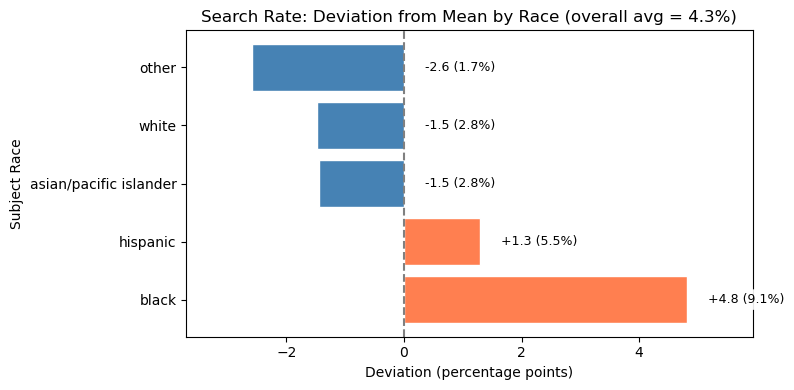

In [6]:
race_plot = race_summary.head(6).copy()
overall_rate_pct = overall_rate * 100
race_plot['deviation_pp'] = race_plot['search_rate_pct'] - overall_rate_pct
fig, ax = plt.subplots(figsize=(8, 4))
vals = race_plot['deviation_pp']
colors = ['steelblue' if v < 0 else 'coral' for v in vals]
bars = ax.barh(race_plot['subject_race'], vals, color=colors, edgecolor='white')
ax.axvline(0, color='gray', linestyle='--', label='Overall mean')
ax.set_title(f'Search Rate: Deviation from Mean by Race (overall avg = {overall_rate_pct:.1f}%)')
ax.set_xlabel('Deviation (percentage points)')
ax.set_ylabel('Subject Race')
ax.margins(x=0.15)
bbox_props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='none')
for bar, dev, pct in zip(bars, race_plot['deviation_pp'], race_plot['search_rate_pct']):
    w = bar.get_width()
    # For negative bars: put label to the right of zero to avoid overlap with y-axis race labels
    if w >= 0:
        x, ha = w + 0.35, 'left'
    else:
        x, ha = 0.35, 'left'
    ax.text(x, bar.get_y() + bar.get_height()/2, f'{dev:+.1f} ({pct:.1f}%)', ha=ha, va='center', fontsize=9, bbox=bbox_props)
plt.tight_layout()
plt.show()

### Graph 3: Search Rate by Reason for Stop

**Insight:** Search rates rise sharply for non-traffic stops (e.g., Radio Call/Citizen Contact) vs routine traffic.

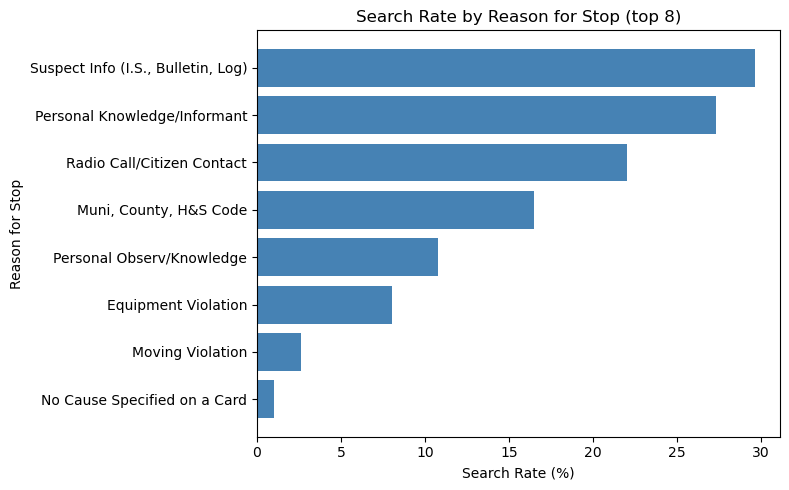

In [7]:
top_reasons = df['reason_for_stop'].value_counts().head(8).index.tolist()
reason_df = df[df['reason_for_stop'].isin(top_reasons)]
reason_rates = reason_df.groupby('reason_for_stop').agg(
    n=('search_conducted', 'size'),
    search_rate=('search_conducted', lambda x: x.eq(True).mean())
).reset_index().sort_values('search_rate', ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(reason_rates['reason_for_stop'], reason_rates['search_rate'] * 100, color='steelblue')
ax.set_title('Search Rate by Reason for Stop (top 8)')
ax.set_xlabel('Search Rate (%)')
ax.set_ylabel('Reason for Stop')
plt.tight_layout()
plt.show()

### Graph 4: Day vs Night

**Insight:** Night stops (6pm–6am) have higher search rates than day stops, possibly due to different stop types or visibility concerns.

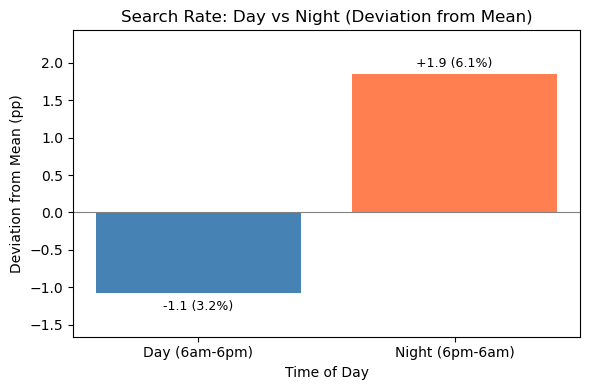

In [8]:
tmp_valid = df.dropna(subset=['hour'])
day_night = tmp_valid.groupby('is_night').agg(
    n=('search_conducted', 'size'),
    search_rate=('search_conducted', lambda x: x.eq(True).mean())
).reset_index()
day_night['period'] = day_night['is_night'].map({True: 'Night (6pm-6am)', False: 'Day (6am-6pm)'})

# Deviation from overall mean (percentage points)
overall_rate_pct = overall_rate * 100
day_night['deviation'] = (day_night['search_rate'] * 100) - overall_rate_pct
day_night['search_rate_pct'] = day_night['search_rate'] * 100

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['steelblue' if d < 0 else 'coral' for d in day_night['deviation']]
bars = ax.bar(day_night['period'], day_night['deviation'], color=colors)
ax.axhline(0, color='gray', linewidth=0.8)
ax.set_title('Search Rate: Day vs Night (Deviation from Mean)')
ax.set_ylabel('Deviation from Mean (pp)')
ax.set_xlabel('Time of Day')
ax.margins(y=0.2)
for i, (bar, row) in enumerate(zip(bars, day_night.itertuples())):
    y = row.deviation
    label = f'{y:+.1f} ({row.search_rate_pct:.1f}%)'
    ax.annotate(label, xy=(bar.get_x() + bar.get_width()/2, y),
                xytext=(0, 5 if y >= 0 else -12), textcoords='offset points',
                ha='center', fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none'))
plt.tight_layout()
plt.show()

### Graph 5: Monthly Stops Over Time

**Insight:** Total stops and search rate by month reveal trends and seasonal patterns. Each line is a year (2014–2017); x-axis is month (Jan–Dec) for easy comparison across years.

In [9]:
# Generate EDA Report PDF
from matplotlib.backends.backend_pdf import PdfPages

def wrap_text(text, width=90):
    words = text.split()
    lines = []
    current = []
    for w in words:
        if len(' '.join(current + [w])) <= width:
            current.append(w)
        else:
            if current:
                lines.append(' '.join(current))
            current = [w]
    if current:
        lines.append(' '.join(current))
    return lines

def add_text_page(pdf, title, body_paragraphs, fontsize_title=16, fontsize_body=10):
    fig = plt.figure(figsize=(8.5, 11))
    fig.text(0.5, 0.95, title, ha='center', fontsize=fontsize_title, fontweight='bold')
    y = 0.88
    for para in body_paragraphs:
        for line in wrap_text(para):
            fig.text(0.1, y, line, ha='left', va='top', fontsize=fontsize_body)
            y -= 0.04
        y -= 0.02
    plt.axis('off')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

n_total = len(df)
n_searched = int(df['search_conducted'].sum())
overall_rate_pct = overall_rate * 100

with PdfPages('EDA Report.pdf') as pdf:
    # Title page
    fig = plt.figure(figsize=(8.5, 11))
    fig.text(0.5, 0.6, 'EDA Report', ha='center', fontsize=24, fontweight='bold')
    fig.text(0.5, 0.5, 'San Diego Police Stops + Social Vulnerability Index', ha='center', fontsize=14)
    fig.text(0.5, 0.4, 'Exploratory Data Analysis', ha='center', fontsize=12)
    fig.text(0.5, 0.2, f'Data: {n_total:,} stops (2014–2017)', ha='center', fontsize=10)
    plt.axis('off')
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Executive Summary
    add_text_page(pdf, '1. Executive Summary', [
        'This report summarizes key findings from exploratory data analysis of San Diego police traffic and pedestrian stops merged with Census tract-level Social Vulnerability Index (SVI) data.',
        f'The dataset contains {n_total:,} stops from 2014–2017. Of these, {n_searched:,} involved a search (overall search rate: {overall_rate_pct:.2f}%).',
        'Key findings: (1) Search rates are ~2.3× higher in high-vulnerability areas (Q4) than low (Q1). (2) Black subjects have the highest search rate across all SVI quartiles. (3) Stop context—reason for stop and time of day—strongly affects search likelihood. (4) Neighborhood vulnerability is associated with search rates independent of demographics.'
    ])

    # Target Variable Summary
    add_text_page(pdf, '2. Target Variable Summary', [
        f'Total stops: {n_total:,}', f'Stops with search: {n_searched:,}', f'Overall search rate: {overall_rate_pct:.2f}%', '',
        'By year: 2014 had the highest search rate (4.92%); 2015 and 2016 were lower (~3.8%); 2017 data covers only Jan–Mar with a rate of 4.38%.'
    ])

    # SVI analysis
    svi_text = 'Search rate by SVI quartile: ' + '; '.join([f"{r['svi_quartile']}: {r['search_rate_pct']}%" for _, r in svi_summary.iterrows()])
    add_text_page(pdf, '3. Search Rate by Place (SVI Quartile)', [
        'The Social Vulnerability Index measures census-tract vulnerability. Q1 = lowest, Q4 = highest.', svi_text,
        'Analysis: Search rates rise sharply with vulnerability. Q4 areas have ~2.3× the search rate of Q1.'
    ])

    # Race analysis
    race_text = 'Top groups: ' + '; '.join([f"{r['subject_race']}: {r['search_rate_pct']}%" for _, r in race_summary.head(5).iterrows()])
    add_text_page(pdf, '4. Search Rate by Race', [
        race_text,
        'Analysis: Black subjects have the highest search rate (9.07%), over 3× the rate for white and Asian/Pacific Islander subjects. Disparities persist within each SVI quartile.'
    ])

    # Graph 1: SVI
    ratio = svi_summary['ratio_to_baseline'].values
    labels = svi_summary['svi_quartile'].astype(str).tolist()
    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(range(len(labels)), ratio, color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c'])
    ax.axhline(1, color='gray', linestyle='--')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_ylabel('Ratio to Overall Baseline')
    ax.set_title('Graph 1: Search Rate by SVI Quartile')
    for b, v in zip(bars, ratio):
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.05, f'{v:.2f}×', ha='center', fontsize=9)
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Graph 2: Race
    race_plot = race_summary.head(6)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(range(len(race_plot)), race_plot['search_rate_pct'], color='steelblue')
    ax.set_xticks(range(len(race_plot)))
    ax.set_xticklabels(race_plot['subject_race'], rotation=30, ha='right')
    ax.set_ylabel('Search Rate (%)')
    ax.set_title('Graph 2: Search Rate by Race')
    ax.axhline(overall_rate_pct, color='coral', linestyle='--', label=f'Overall ({overall_rate_pct:.1f}%)')
    ax.legend()
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Graph 3: Reason for Stop
    top_reasons = df['reason_for_stop'].value_counts().head(8).index.tolist()
    reason_df = df[df['reason_for_stop'].isin(top_reasons)]
    reason_summary = reason_df.groupby('reason_for_stop').agg(search_rate=('search_conducted', lambda x: x.eq(True).mean())).reset_index()
    reason_summary = reason_summary.sort_values('search_rate', ascending=False)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.barh(range(len(reason_summary)), reason_summary['search_rate'] * 100, color='steelblue')
    ax.set_yticks(range(len(reason_summary)))
    ax.set_yticklabels(reason_summary['reason_for_stop'], fontsize=9)
    ax.set_xlabel('Search Rate (%)')
    ax.set_title('Graph 3: Search Rate by Reason for Stop')
    ax.axvline(overall_rate_pct, color='coral', linestyle='--', alpha=0.8)
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Graph 4: Day vs Night
    daynight = df.groupby('is_night').agg(search_rate=('search_conducted', lambda x: x.eq(True).mean())).reset_index()
    daynight['label'] = daynight['is_night'].map({True: 'Night (6pm–6am)', False: 'Day'})
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(daynight['label'], daynight['search_rate'] * 100, color=['steelblue', 'coral'])
    ax.set_ylabel('Search Rate (%)')
    ax.set_title('Graph 4: Search Rate by Day vs Night')
    ax.axhline(overall_rate_pct, color='gray', linestyle='--', alpha=0.7)
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Graph 5: Monthly
    monthly = df.groupby([df['date'].dt.year.rename('year'), df['date'].dt.month.rename('month')]).size().reset_index(name='n_stops')
    monthly_pivot = monthly.pivot(index='month', columns='year', values='n_stops')
    monthly_search = df.groupby([df['date'].dt.year.rename('year'), df['date'].dt.month.rename('month')]).agg(search_rate=('search_conducted', lambda x: x.eq(True).mean())).reset_index()
    search_pivot = monthly_search.pivot(index='month', columns='year', values='search_rate') * 100
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    monthly_pivot.plot(ax=axes[0], marker='o', markersize=4)
    axes[0].set_title('Number of Stops per Month (by Year)')
    axes[0].set_ylabel('Stops')
    axes[0].set_xlabel('Month')
    axes[0].set_xticks(range(1, 13))
    axes[0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    axes[0].legend(title='Year')
    search_pivot.plot(ax=axes[1], marker='o', markersize=4)
    axes[1].set_title('Search Rate per Month (by Year)')
    axes[1].set_ylabel('Search Rate (%)')
    axes[1].set_xlabel('Month')
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    axes[1].legend(title='Year')
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    # Summary
    add_text_page(pdf, '5. Summary & Conclusions', [
        '1. SVI: Search rates are ~2.3× higher in high-vulnerability areas (Q4) than low (Q1).',
        '2. Race: Black subjects have the highest search rate; disparities persist across SVI quartiles.',
        '3. Context: Search rates rise for non-traffic stops vs routine traffic; night stops have higher search rates.',
        '4. Volume: Monthly stop counts show seasonal variation; 2017 data is partial (Jan–Mar only).',
        '', 'These patterns suggest both place and demographics are associated with search likelihood.'
    ])

print('Report saved to EDA Report.pdf')

Report saved to EDA Report.pdf


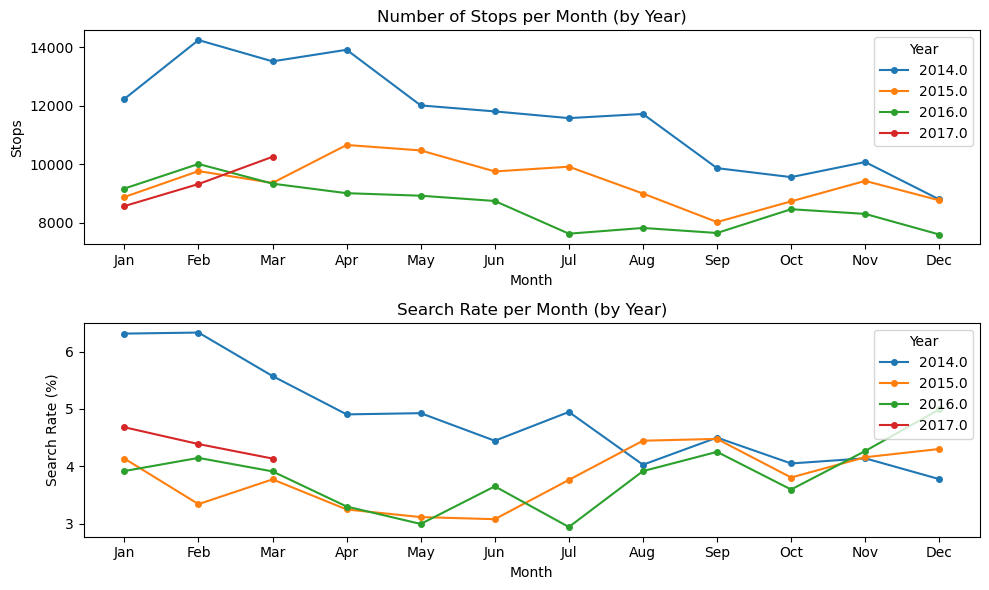

In [10]:
# Month (1-12) on x-axis, one line per year for clearer comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
monthly = df.groupby([df['date'].dt.year.rename('year'), df['date'].dt.month.rename('month')]).size().reset_index(name='n_stops')
monthly_pivot = monthly.pivot(index='month', columns='year', values='n_stops')
monthly_pivot.plot(ax=axes[0], marker='o', markersize=4)
axes[0].set_title('Number of Stops per Month (by Year)')
axes[0].set_ylabel('Stops')
axes[0].set_xlabel('Month')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
axes[0].legend(title='Year')

monthly_search = df.groupby([df['date'].dt.year.rename('year'), df['date'].dt.month.rename('month')]).agg(
    search_rate=('search_conducted', lambda x: x.eq(True).mean())
).reset_index()
search_pivot = monthly_search.pivot(index='month', columns='year', values='search_rate') * 100
search_pivot.plot(ax=axes[1], marker='o', markersize=4)
axes[1].set_title('Search Rate per Month (by Year)')
axes[1].set_ylabel('Search Rate (%)')
axes[1].set_xlabel('Month')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
axes[1].legend(title='Year')
plt.tight_layout()
plt.show()

## 4. Summary

**Key takeaways:**
1. **SVI:** Search rates are ~2.3× higher in high-vulnerability areas (Q4) than low (Q1).
2. **Race:** Black subjects have the highest search rate; disparities persist across SVI quartiles.
3. **Context:** Stop reason (Radio Call vs Moving Violation) and time of day affect search likelihood.
4. **Place:** Neighborhood vulnerability is strongly associated with search rates, independent of demographics.